In [1]:
%pip install fastbook -Uqq
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 12.2 MB/s 
     |████████████████████████████████| 1.2 MB 31.7 MB/s 
     |████████████████████████████████| 186 kB 45.4 MB/s 
     |████████████████████████████████| 46 kB 3.9 MB/s 
     |████████████████████████████████| 56 kB 3.9 MB/s 
     |████████████████████████████████| 51 kB 355 kB/s 
Mounted at /content/gdrive


In [38]:
%pip install nbdev -qq

# MNIST CNN

Reference:
- [fastai - Lesson 7 Resnet on MNIST](https://nbviewer.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson7-resnet-mnist.ipynb)
- https://walkwithfastai.com/MNIST

In [40]:
from fastai.vision.all import *
from nbdev.showdoc import show_doc

## Data

In [3]:
path = untar_data(URLs.MNIST)

In [4]:
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/training'),Path('/root/.fastai/data/mnist_png/testing')]

In [5]:
fnames = get_image_files(path)

In [6]:
fnames[0]

Path('/root/.fastai/data/mnist_png/training/5/1817.png')

In [7]:
PILImageBW.create(fnames[0])

In [8]:
parent_label(fnames[0])

'5'

### DataBlock approach

In [9]:
'''
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
Pipeline: PILBase.create
    starting from
      /root/.fastai/data/mnist_png/training/3/13332.png
    applying PILBase.create gives
      PILImageBW mode=L size=28x28
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/mnist_png/training/3/13332.png
    applying parent_label gives
      3
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(3)
Final sample: (PILImageBW mode=L size=28x28, TensorCategory(3))
'''
db = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
               get_items=get_image_files,
               get_y=parent_label, 
               splitter=GrandparentSplitter(train_name='training', valid_name='testing'))

In [10]:
dset = db.datasets(path, True)

Found 70000 items
2 datasets of sizes 60000,10000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}


In [11]:
dset.train[0]

(PILImageBW mode=L size=28x28, TensorCategory(5))

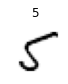

In [12]:
dset.show(dset.train[0])

Transforms
- Ensure our images are all the same size
- Make sure our output are the tensor our models are wanting
- Give some image augmentation

In [13]:
# ToTensor: Converts to Tensor
# CropPad & RandomCrop : Resizing Transforms
# Applied on CPU via after_item
tfms=[ToTensor(), CropPad(size=34, pad_mode=PadMode.Zeros), RandomCrop(size=28)]

In [14]:
# IntToFloatTensor : Converts to a float
# Normalize: Normalizes data
gpu_tfms=[IntToFloatTensor(), Normalize()]

In [15]:
dls = dset.dataloaders(bs=128, after_item=tfms, after_batch=gpu_tfms)

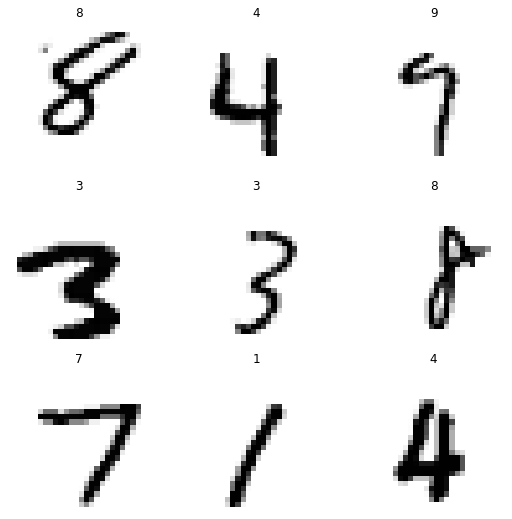

In [16]:
dls.show_batch()

In [17]:
xb, yb = dls.one_batch()

In [18]:
xb.shape, yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [19]:
dls.c

10

## Model

### Basic CNN with batchnorm

In [20]:
#Here we can see our ni is equivalent to the depth of the filter, and nf is equivalent to how many filters we will be using. (Fun fact this always has to be divisible by the size of our image).
def conv(ni, nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [21]:
def bn(nf): return nn.BatchNorm2d(nf)

In [22]:
def ReLU(): return nn.ReLU(inplace=False)

In [23]:
# Flatten `x` to a single dimension, e.g. at end of a model. `full` for rank-1 tensor
Flatten()

Flatten(full=False)

In [24]:
model = nn.Sequential(
    conv(1, 8), # 14
    bn(8),
    ReLU(),
    conv(8, 16), # 7
    bn(16),
    ReLU(), 
    conv(16, 32), # 4
    bn(32),
    ReLU(),
    conv(32, 16), # 2
    bn(16),
    ReLU(),
    conv(16, 10), # 1
    bn(10),
    Flatten() # remove(1, 1) grid   
)

In [25]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [26]:
learn.summary()

Sequential (Input shape: 128)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 8 x 14 x 14   
Conv2d                                    80         True      
BatchNorm2d                               16         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 16 x 7 x 7    
Conv2d                                    1168       True      
BatchNorm2d                               32         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 32 x 4 x 4    
Conv2d                                    4640       True      
BatchNorm2d                               64         True      
ReLU                                                           
__________________________________________________

In [27]:
xb = xb.cuda()
model(xb).shape

torch.Size([128, 10])

SuggestedLRs(valley=0.0063095735386013985)

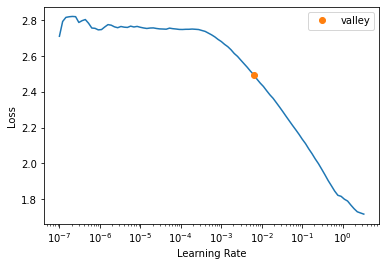

In [28]:
learn.lr_find()

In [29]:
learn.fit_one_cycle(3, lr_max=6e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.240978,0.122962,0.969600,02:07
1,0.110139,0.055658,0.985200,02:06
2,0.078175,0.044224,0.988600,02:07


## Refactor

In [41]:
show_doc(ConvLayer)

<h2 id="ConvLayer" class="doc_header"><code>class</code> <code>ConvLayer</code><a href="https://github.com/fastai/fastai/tree/master/fastai/layers.py#L237" class="source_link" style="float:right">[source]</a></h2>

> <code>ConvLayer</code>(**`ni`**, **`nf`**, **`ks`**=*`3`*, **`stride`**=*`1`*, **`padding`**=*`None`*, **`bias`**=*`None`*, **`ndim`**=*`2`*, **`norm_type`**=*`<NormType.Batch: 1>`*, **`bn_1st`**=*`True`*, **`act_cls`**=*`ReLU`*, **`transpose`**=*`False`*, **`init`**=*`'auto'`*, **`xtra`**=*`None`*, **`bias_std`**=*`0.01`*, **`dilation`**:`Union`\[`int`, `Tuple`\[`int`, `int`\]\]=*`1`*, **`groups`**:`int`=*`1`*, **`padding_mode`**:`str`=*`'zeros'`*, **`device`**=*`None`*, **`dtype`**=*`None`*) :: `Sequential`

Create a sequence of convolutional (`ni` to `nf`), ReLU (if `use_activ`) and `norm_type` layers.

In [42]:
# Create a sequence of convolutional (ni to nf), ReLU and norm_type layers.
def conv2(ni, nf): return ConvLayer(ni, nf, stride=2)

In [43]:
net = nn.Sequential(
    conv2(1, 8),
    conv2(8, 16),
    conv2(16, 32),
    conv2(32, 16),
    conv2(16, 10),
    Flatten()
)

In [44]:
learn = Learner(dls, net,loss_func=CrossEntropyLossFlat(), metrics=accuracy)

SuggestedLRs(valley=0.010964781977236271)

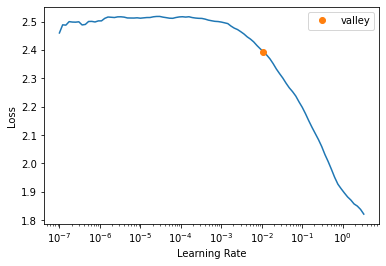

In [45]:
learn.lr_find()

In [46]:
learn.fit_one_cycle(3, lr_max=0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.244206,0.146792,0.961500,02:07
1,0.118846,0.066031,0.980400,02:08
2,0.087754,0.046837,0.985900,02:07


## Resnet-ish

In [51]:
show_doc(ConvLayer)

<h2 id="ConvLayer" class="doc_header"><code>class</code> <code>ConvLayer</code><a href="https://github.com/fastai/fastai/tree/master/fastai/layers.py#L237" class="source_link" style="float:right">[source]</a></h2>

> <code>ConvLayer</code>(**`ni`**, **`nf`**, **`ks`**=*`3`*, **`stride`**=*`1`*, **`padding`**=*`None`*, **`bias`**=*`None`*, **`ndim`**=*`2`*, **`norm_type`**=*`<NormType.Batch: 1>`*, **`bn_1st`**=*`True`*, **`act_cls`**=*`ReLU`*, **`transpose`**=*`False`*, **`init`**=*`'auto'`*, **`xtra`**=*`None`*, **`bias_std`**=*`0.01`*, **`dilation`**:`Union`\[`int`, `Tuple`\[`int`, `int`\]\]=*`1`*, **`groups`**:`int`=*`1`*, **`padding_mode`**:`str`=*`'zeros'`*, **`device`**=*`None`*, **`dtype`**=*`None`*) :: `Sequential`

Create a sequence of convolutional (`ni` to `nf`), ReLU (if `use_activ`) and `norm_type` layers.

In [54]:
ConvLayer

fastai.layers.ConvLayer

In [55]:
class ResBlock(Module):
  def __init__(self, nf):
    self.conv1 = ConvLayer(nf, nf)
    self.conv2 = ConvLayer(nf, nf)

  def forward(self, x): return self.conv2(self.conv1(x)) + x

In [56]:
net = nn.Sequential(
    conv2(1, 8),
    ResBlock(8),
    conv2(8, 16),
    ResBlock(16),
    conv2(16, 32),
    ResBlock(32),
    conv2(32, 16),
    ResBlock(16),
    conv2(16, 10),
    Flatten()
)

In [57]:
net

Sequential(
  (0): ConvLayer(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ResBlock(
    (conv1): ConvLayer(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): ConvLayer(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (2): ConvLayer(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): ResBlock(
    (conv1): ConvLayer(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride

In [58]:
def conv_and_res(ni, nf): return nn.Sequential(conv2(ni, nf), ResBlock(nf))

In [59]:
net = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [60]:
learn = Learner(dls, net, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [62]:
learn.fit_one_cycle(3, lr_max=0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.182298,0.399562,0.869300,02:13
1,0.091580,0.057553,0.983600,02:12
2,0.044026,0.028930,0.991000,02:13


Resnet = x + conv2(conv1(x))

DenseNet: cat(x.orig, conv2(conv1(x)) - Works well for small datasets and for segmentations